In [151]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
from patsy import dmatrix

import causalpy as cp

In [137]:
N = 1000


def inv_logit(x):
    return 1 / (1 + np.exp(-x))


df1 = pd.DataFrame(
    np.random.multivariate_normal([0.5, 1], [[2, 1], [1, 1]], size=N),
    columns=["x1", "x2"],
)
df1["trt"] = np.where(
    -0.5 + 0.25 * df1["x1"] + 0.75 * df1["x2"] + np.random.normal(0, 1, size=N) > 0,
    1,
    0,
)
TREATMENT_EFFECT = 2
df1["outcome"] = (
    4
    + TREATMENT_EFFECT * df1["trt"]
    + df1["x1"]
    + df1["x2"]
    + np.random.normal(0, 1, size=N)
)
df1.head()

,x1,x2,trt,outcome
0,0.324714,0.121073,1,7.206744
1,-1.257066,-0.400438,0,1.865809
2,1.491616,1.693848,1,9.825401
3,2.413023,2.385870,1,9.819792
4,1.128825,1.699364,1,9.099724


In [225]:
B_ = dmatrix(
    "bs(ps, knots=knots, degree=3, include_intercept=True) - 1",
    {"ps": np.linspace(0, 1, 100), "knots": np.linspace(0, 1, 12)[1:-1]},
)
B_f = np.asarray(B_, order="F")

B_f.shape

(100, 14)

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


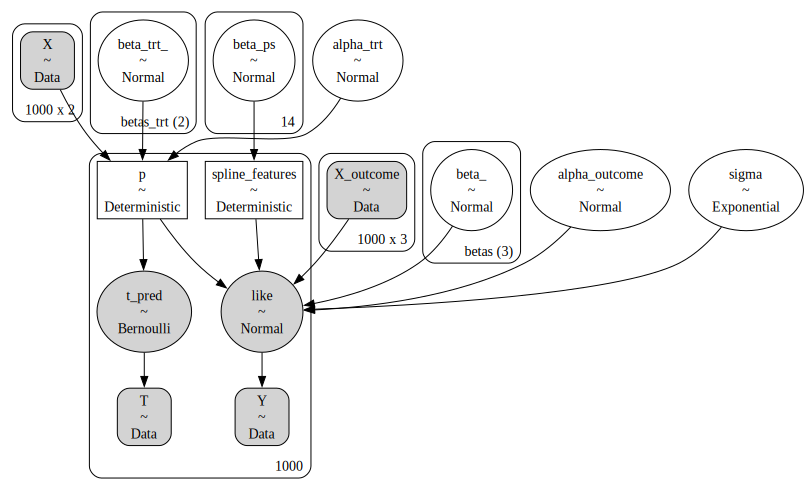

In [ ]:
coords = {
    "betas": ["trt", "x1", "x2"],
    "betas_trt": ["x1", "x2"],
    "obs": range(df1.shape[0]),
}

N = df1.shape[0]
X_trt = df1[["x1", "x2"]].values
X_outcome = df1[["trt", "x1", "x2"]].values
T_data = df1["trt"].values
Y_data = df1["outcome"].values


def make_model(
    X_trt,
    X_outcome,
    T_data,
    Y_data,
    coords,
    priors={"beta_": [0, 1], "beta_trt": [0, 1]},
):
    with pm.Model(coords=coords) as model:
        X_data_trt = pm.Data("X", X_trt)
        X_data_outcome = pm.Data("X_outcome", X_outcome)
        T_data_ = pm.Data("T", T_data, mutable=True)
        Y_data_ = pm.Data("Y", Y_data)

        beta_trt = pm.Normal(
            "beta_trt_", priors["beta_trt"][0], priors["beta_trt"][1], dims="betas_trt"
        )
        beta = pm.Normal("beta_", priors["beta_"][0], priors["beta_"][1], dims="betas")
        beta_ps = pm.Normal("beta_ps", 0, 1, size=14)

        alpha_trt = pm.Normal("alpha_trt", 0, 1)
        mu_trt = alpha_trt + pm.math.dot(X_data_trt, beta_trt)
        p = pm.Deterministic("p", pm.math.invlogit(mu_trt))

        pm.Bernoulli("t_pred", p=p, observed=T_data_)

        B = dmatrix(
            "bs(ps, knots=knots, degree=3, include_intercept=True) - 1",
            {"ps": np.linspace(0, 1, X_trt.shape[0]), "knots": np.linspace(0, 1, 10)},
        )
        B_f = np.asarray(B, order="F")
        splines_summed = pm.Deterministic(
            "spline_features", pm.math.dot(B_f, beta_ps.T)
        )

        alpha_outcome = pm.Normal("alpha_outcome", 0, 1)
        mu_outcome = (
            alpha_outcome + pm.math.dot(X_data_outcome, beta) + p * splines_summed
        )
        sigma = pm.Exponential("sigma", 1)

        # p_of_t = T_data.mean()
        # p_inv = pm.math.where(T_data == 1, p_of_t/p, (1- p_of_t)/(1 - p))
        # trted = pm.math.sum(p_inv[T_data == 1]*Y_data[T_data == 1])
        # ntrted = pm.math.sum(p_inv[T_data == 0]*Y_data[T_data == 0])
        # ate = pm.Deterministic('ate', (trted / Y_data[T_data == 1].shape[0]) - (ntrted / Y_data[T_data == 0].shape[0]))

        # _ = pm.Deterministic("weighted_outcome", p_inv * Y_data_)
        _ = pm.Normal("like", mu_outcome, sigma, observed=Y_data_)

    return model


model = make_model(X_trt, X_outcome, T_data, Y_data, coords)

pm.model_to_graphviz(model)

In [239]:
with model:
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(tune=2000, target_accept=0.95, nuts_sampler="numpyro"))

Sampling: [alpha_outcome, alpha_trt, beta_, beta_ps, beta_trt_, like, sigma, t_pred]


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [240]:
az.summary(
    idata, var_names=["alpha_trt", "beta_trt_", "alpha_outcome", "beta_", "beta_ps"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_trt,-0.983,0.123,-1.208,-0.744,0.002,0.001,3807.0,2630.0,1.0
beta_trt_[x1],0.320,0.079,0.170,0.461,0.001,0.001,3884.0,2685.0,1.0
beta_trt_[x2],1.331,0.125,1.082,1.543,0.002,0.002,3509.0,2868.0,1.0
alpha_outcome,4.023,0.101,3.834,4.208,0.003,0.002,1305.0,1981.0,1.0
beta_[trt],1.999,0.081,1.844,2.151,0.001,0.001,5219.0,2681.0,1.0
beta_[x1],0.998,0.036,0.926,1.061,0.001,0.000,3413.0,3054.0,1.0
beta_[x2],1.049,0.071,0.916,1.179,0.002,0.001,1729.0,2017.0,1.0
beta_ps[0],0.021,1.011,-1.885,1.836,0.014,0.018,5508.0,2927.0,1.0
beta_ps[1],0.161,0.473,-0.694,1.085,0.010,0.007,2414.0,2156.0,1.0
beta_ps[2],0.006,0.515,-1.004,0.962,0.010,0.008,2587.0,2836.0,1.0


In [241]:
X_outcome_trt = X_outcome.copy()
X_outcome_trt[:, 0] = 1

X_outcome_ntrt = X_outcome.copy()
X_outcome_ntrt[:, 0] = 0

In [242]:
with pm.do(
    model,
    {"T": np.ones(len(df1), dtype=np.int32), "X_outcome": X_outcome_trt},
    prune_vars=True,
) as treatment_model:
    idata_trt = pm.sample_posterior_predictive(idata, var_names=["like", "p"])

with pm.do(
    model,
    {"T": np.zeros(len(df1), dtype=np.int32), "X_outcome": X_outcome_ntrt},
    prune_vars=True,
) as ntreatment_model:
    idata_ntrt = pm.sample_posterior_predictive(idata, var_names=["like", "p"])

Sampling: [like]


Output()

Sampling: [like]


Output()

In [243]:
idata_trt["posterior_predictive"]["like"].mean()

<xarray.DataArray 'like' ()> Size: 8B
array(7.51624705)

In [244]:
idata_ntrt["posterior_predictive"]["like"].mean()

<xarray.DataArray 'like' ()> Size: 8B
array(5.51650717)

In [245]:
(
    idata_trt["posterior_predictive"]["like"].mean()
    - idata_ntrt["posterior_predictive"]["like"].mean()
)

<xarray.DataArray 'like' ()> Size: 8B
array(1.99973988)

## Nets Example



In [246]:
nets_df = pd.read_csv("../../../causalpy/data/nets_df.csv")
nets_df["trt"] = nets_df["net_num"]
nets_df["outcome"] = nets_df["malaria_risk"]
nets_df

,id,net,net_num,malaria_risk,income,health,household,eligible,temperature,resistance,trt,outcome
0,1,True,1,33,781,56,2,False,21.1,59,1,33
1,2,False,0,42,974,57,4,False,26.5,73,0,42
2,3,False,0,80,502,15,3,False,25.6,65,0,80
3,4,True,1,34,671,20,5,True,21.3,46,1,34
4,5,False,0,44,728,17,5,False,19.2,54,0,44
...,...,...,...,...,...,...,...,...,...,...,...,...
1747,1748,True,1,18,961,27,4,False,22.1,27,1,18
1748,1749,False,0,49,906,49,5,False,30.7,55,0,49
1749,1750,False,0,17,1325,92,2,False,21.4,52,0,17
1750,1751,False,0,46,879,33,6,False,27.4,62,0,46


/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


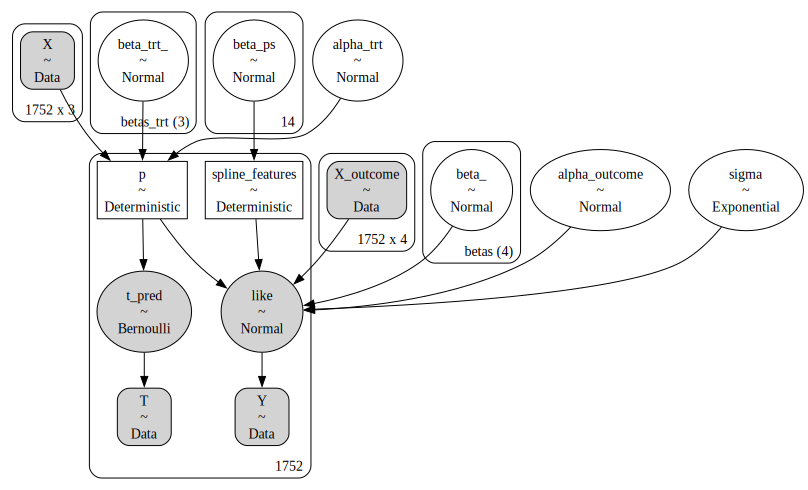

In [247]:
coords = {
    "betas": ["trt", "income", "temperature", "health"],
    "betas_trt": ["income", "temperature", "health"],
    "obs": range(nets_df.shape[0]),
}

N = nets_df.shape[0]
X_trt = nets_df[["income", "temperature", "health"]].values
X_outcome = nets_df[["trt", "income", "temperature", "health"]].values
T_data = nets_df["trt"].values
Y_data = nets_df["outcome"].values

priors = {"beta_": [0, 5], "beta_trt": [0, 5]}
net_model = make_model(X_trt, X_outcome, T_data, Y_data, coords, priors=priors)

pm.model_to_graphviz(net_model)

In [248]:
with net_model:
    idata_net = pm.sample(tune=2000, target_accept=0.97)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_, beta_, beta_ps, alpha_trt, alpha_outcome, sigma]
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 100 seconds.


In [249]:
az.summary(idata_net, var_names=["beta_", "beta_ps"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_[trt],-9.462,0.440,-10.268,-8.662,0.007,0.005,4147.0,3036.0,1.0
beta_[income],-0.044,0.002,-0.047,-0.040,0.000,0.000,2086.0,2376.0,1.0
beta_[temperature],2.340,0.045,2.262,2.430,0.001,0.001,2497.0,2791.0,1.0
beta_[health],0.008,0.018,-0.025,0.042,0.000,0.000,2515.0,2726.0,1.0
beta_ps[0],-0.024,0.966,-1.878,1.699,0.014,0.015,4606.0,3433.0,1.0
beta_ps[1],0.175,0.966,-1.589,2.086,0.015,0.014,4397.0,3169.0,1.0
beta_ps[2],0.427,0.967,-1.455,2.182,0.015,0.015,4161.0,2692.0,1.0
beta_ps[3],0.519,0.966,-1.243,2.353,0.016,0.013,3763.0,2926.0,1.0
beta_ps[4],0.584,0.980,-1.241,2.441,0.015,0.013,4084.0,3062.0,1.0
beta_ps[5],0.997,0.941,-0.765,2.751,0.016,0.012,3495.0,2891.0,1.0


## LaLonde Example

In [250]:
lalonde = pd.read_csv(
    "https://vincentarelbundock.github.io/Rdatasets/csv/MatchIt/lalonde.csv"
)
lalonde[["hispan", "white"]] = pd.get_dummies(lalonde["race"], drop_first=True)
lalonde.dropna(inplace=True)

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


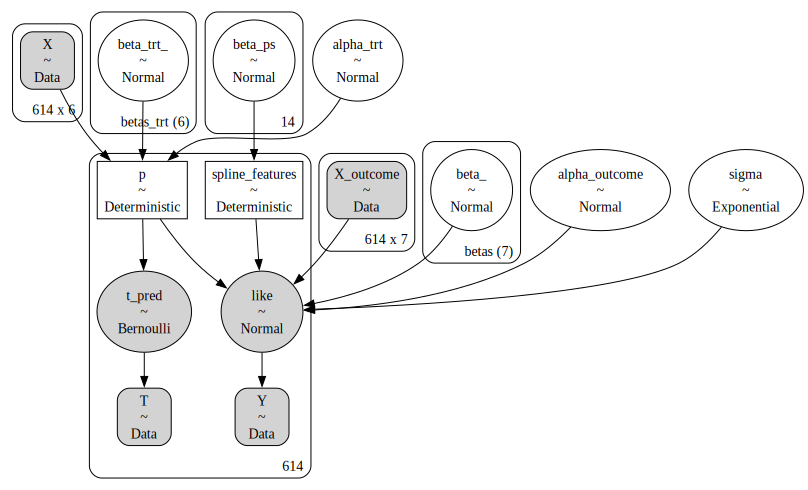

In [251]:
coords = {
    "betas": ["treat", "age", "educ", "hispan", "white", "married", "nodegree"],
    "betas_trt": ["age", "educ", "hispan", "white", "married", "nodegree"],
    "obs": range(lalonde.shape[0]),
}

N = lalonde.shape[0]
X_trt = (
    lalonde[["age", "educ", "hispan", "white", "married", "nodegree"]]
    .astype(np.int32)
    .values
)
X_outcome = (
    lalonde[["treat", "age", "educ", "hispan", "white", "married", "nodegree"]]
    .astype(np.int32)
    .values
)
T_data = lalonde["treat"].values
Y_data = lalonde["re78"].values

priors = {"beta_": [0, 4000], "beta_trt": [0, 4000]}

lalonde_model = make_model(X_trt, X_outcome, T_data, Y_data, coords, priors)

pm.model_to_graphviz(lalonde_model)

In [252]:
with lalonde_model:
    idata_lalonde = pm.sample(tune=5000, nuts_sampler="numpyro")

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [253]:
az.summary(idata_lalonde, var_names=["beta_", "beta_ps"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_[treat],1047.659,335.777,391.341,1651.536,6.156,4.353,2985.0,2999.0,1.0
beta_[age],40.726,11.788,18.818,62.851,0.216,0.153,2996.0,2626.0,1.0
beta_[educ],391.866,30.432,335.873,449.219,0.598,0.425,2589.0,2699.0,1.0
beta_[hispan],1898.338,414.456,1104.615,2642.526,6.980,4.992,3525.0,3133.0,1.0
beta_[white],1387.565,327.260,805.609,2027.095,6.101,4.337,2870.0,3163.0,1.0
beta_[married],2121.551,280.729,1610.405,2665.160,4.083,2.904,4738.0,2882.0,1.0
beta_[nodegree],-651.456,238.687,-1093.571,-190.758,3.659,2.614,4258.0,3304.0,1.0
beta_ps[0],-0.010,1.013,-1.862,1.913,0.013,0.017,5914.0,3225.0,1.0
beta_ps[1],0.021,1.003,-1.813,1.892,0.012,0.017,6544.0,3084.0,1.0
beta_ps[2],0.012,1.002,-1.857,1.878,0.012,0.016,6876.0,3090.0,1.0


In [254]:
X_outcome_trt = X_outcome.copy()
X_outcome_trt[:, 0] = 1
X_outcome_trt = X_outcome_trt.astype(np.int32)

X_outcome_ntrt = X_outcome.copy()
X_outcome_ntrt[:, 0] = 0
X_outcome_ntrt = X_outcome_ntrt.astype(np.int32)


with pm.do(
    lalonde_model,
    {"T": np.ones(len(lalonde), dtype=np.int32), "X_outcome": X_outcome_trt},
    prune_vars=True,
) as treatment_model:
    idata_trt = pm.sample_posterior_predictive(idata_lalonde, var_names=["like", "p"])

with pm.do(
    lalonde_model,
    {"T": np.zeros(len(lalonde), dtype=np.int32), "X_outcome": X_outcome_ntrt},
    prune_vars=True,
) as ntreatment_model:
    idata_ntrt = pm.sample_posterior_predictive(idata_lalonde, var_names=["like", "p"])

Sampling: [like]


Output()

Sampling: [like]


Output()

In [255]:
(
    idata_trt["posterior_predictive"]["like"].mean()
    - idata_ntrt["posterior_predictive"]["like"].mean()
)

<xarray.DataArray 'like' ()> Size: 8B
array(1049.17877379)

In [256]:
import statsmodels.formula.api as smf

res = smf.ols(
    "re78 ~ treat + age + educ + hispan + white + married + nodegree", lalonde
).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     6.594
Date:                Tue, 08 Jul 2025   Prob (F-statistic):           1.59e-07
Time:                        12:37:31   Log-Likelihood:                -6324.3
No. Observations:                 614   AIC:                         1.266e+04
Df Residuals:                     606   BIC:                         1.270e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -2352.7506   2540.562     -0.926      0.355   -7342.126    2636.625
hispan[T.True]  2173.6001   1059.746      2.051      0.041      92.380    4254.820
white[T.True]   1538.0720    798.864      1.925      0.055     -30.807    3106.951
treat           1163.9224    811.617      1.434      0.152    -430.001    2757.845
age               55.8953     32.831      1.703      0.089      -8.582     120.372
educ             525.5796    164.381      3.197      0.001     202.753     848.406
married         2136.9467    679.736      3.144      0.002     802.022    3471.871
nodegree         -36.4776    882.377     -0.041      0.967   -1769.367    1696.411
==============================================================================
Omnibus:                      201.275   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              848.900
Skew:                           1.446   Prob(JB):                    4.61e-185
Kurtosis:                       7.982   Cond. No.                         279.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [257]:
df = cp.load_data("nhefs")
df[["age", "race", "trt", "smokeintensity", "smokeyrs", "outcome"]].head()

,age,race,trt,smokeintensity,smokeyrs,outcome
0,42,1,0,30,29,-10.093960
1,36,0,0,20,24,2.604970
2,56,1,0,20,26,9.414486
3,68,1,0,3,53,4.990117
4,40,0,0,20,19,4.989251


In [258]:
coords = {
    "betas": ["trt", "age", "smokeintensity", "smokeyrs", "wt71"],
    "betas_trt": [
        "age",
        "smokeintensity",
        "smokeyrs",
        "wt71",
    ],
    "obs": range(df.shape[0]),
}

N = df.shape[0]
X_trt = df[["age", "smokeintensity", "smokeyrs", "wt71"]]
X_trt = X_trt - X_trt.mean()
X_outcome = df[["trt", "age", "smokeintensity", "smokeyrs", "wt71"]]
X_outcome = X_outcome - X_outcome.mean()
T_data = df["trt"].values
X_outcome["trt"] = T_data
Y_data = df["outcome"].values

new_model = make_model(X_trt, X_outcome, T_data, Y_data, coords)
new_model

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


      beta_trt_ ~ Normal(0, 1)
          beta_ ~ Normal(0, 1)
        beta_ps ~ Normal(0, 1)
      alpha_trt ~ Normal(0, 1)
  alpha_outcome ~ Normal(0, 1)
          sigma ~ Exponential(f())
              p ~ Deterministic(f(beta_trt_, alpha_trt))
spline_features ~ Deterministic(f(beta_ps))
         t_pred ~ Bernoulli(p)
           like ~ Normal(f(beta_, alpha_outcome, beta_ps, beta_trt_, alpha_trt), sigma)

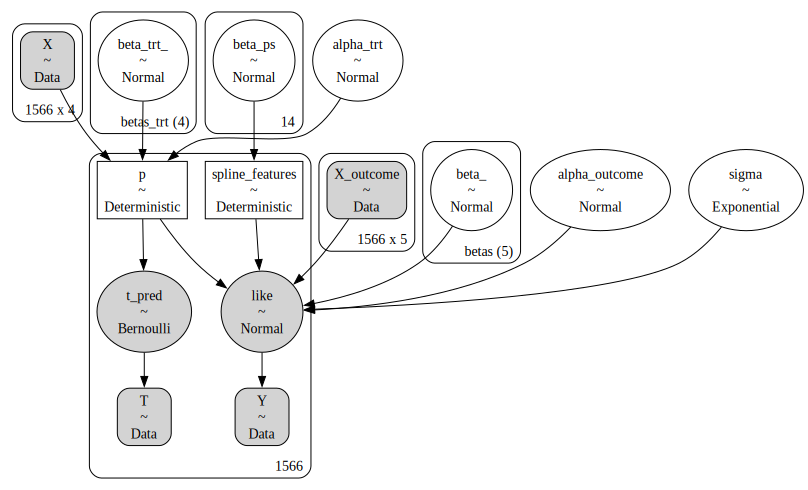

In [259]:
pm.model_to_graphviz(new_model)

In [260]:
with new_model:
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(tune=3000, target_accept=0.99, nuts_sampler="numpyro"))

Sampling: [alpha_outcome, alpha_trt, beta_, beta_ps, beta_trt_, like, sigma, t_pred]


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [261]:
az.summary(
    idata, var_names=["alpha_trt", "beta_trt_", "alpha_outcome", "beta_", "beta_ps"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_trt,-1.098,0.058,-1.208,-0.991,0.001,0.001,4873.0,2928.0,1.0
beta_trt_[age],0.041,0.009,0.023,0.058,0.000,0.000,2778.0,2858.0,1.0
beta_trt_[smokeintensity],-0.018,0.005,-0.028,-0.008,0.000,0.000,6634.0,3058.0,1.0
beta_trt_[smokeyrs],-0.021,0.009,-0.037,-0.003,0.000,0.000,2763.0,3057.0,1.0
beta_trt_[wt71],0.011,0.004,0.003,0.018,0.000,0.000,6050.0,3082.0,1.0
alpha_outcome,1.815,0.223,1.418,2.242,0.004,0.003,3612.0,3115.0,1.0
beta_[trt],2.942,0.388,2.226,3.703,0.006,0.004,4552.0,3427.0,1.0
beta_[age],-0.224,0.032,-0.284,-0.166,0.001,0.000,2758.0,2771.0,1.0
beta_[smokeintensity],0.026,0.017,-0.004,0.059,0.000,0.000,4815.0,3054.0,1.0
beta_[smokeyrs],0.075,0.031,0.015,0.131,0.001,0.000,2795.0,2864.0,1.0


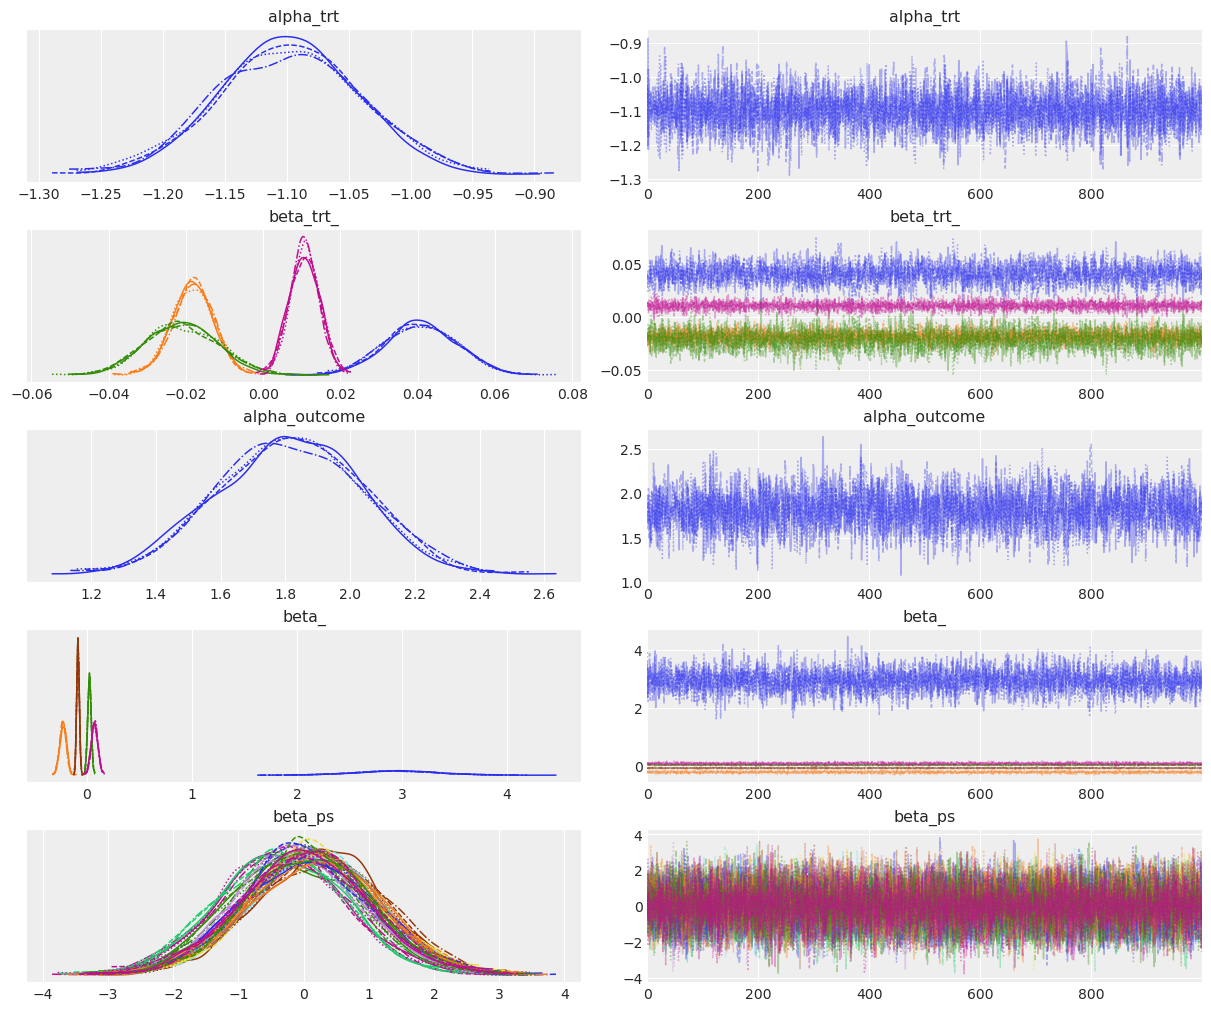

In [262]:
az.plot_trace(
    idata, var_names=["alpha_trt", "beta_trt_", "alpha_outcome", "beta_", "beta_ps"]
);